# Intro

[We seek to predict which customers will respond positively](https://www.kaggle.com/competitions/playground-series-s4e7/overview) to an automobile insurance offer.

Here I'm fitting a NN model optimising cross entropy loss.

We can get funkier with tuning, architecture and data prep. 

I chose to start with a NN because I want to augment the data, which is more difficult using tree-based models. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 200)
from pathlib import Path

from plotnine import *
import os
# suppress tf informational and warning messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras import backend as K

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import preprocessing
from sklearn import metrics

import category_encoders as ce


%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_STATE = 2112
keras.utils.set_random_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# DATA

Using a GAM to visualise the relationships between continuous variables and the outcome.

These are on a logit scale. +ve is in support of customer interest, and negative is against it. For example, we see a peak of interest around age 35. From the parametric table, there are honking effects associated with *previously_insured* and *vehicle_damage*

![](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F175917%2Fc18ae3d96800b05ad34e29207822cf6d%2Fspline%20image.png?generation=1719993590595121&alt=media)

The shapes of the "premium" and "vintage" relationships suggest that they don't reflect real-world (continuous) relationships. So we'll treat everything as categorical (because it works, not because it makes sense). We're going to use an embedding layer for each categorical variable in the NN architecture except the 0-1 ones.

For 'Annual_Premium' we also use an embedding layer (I previously tried both binning and target encoding. It turns out that not "*over thinking*" works better).

In [2]:
INPUT_DIR = Path('/kaggle/input/playground-series-s4e7')
TARGET_NAME = 'Response'

train_data = pd.read_csv(INPUT_DIR / 'train.csv')
test_data = pd.read_csv(INPUT_DIR / 'test.csv')

cont_features = []    
cat_features = [
    'Gender', 'Driving_License', 'Previously_Insured', 
    'Vehicle_Age', 'Vehicle_Damage', 
    'Policy_Sales_Channel', 'Region_Code', 'Age', 'Vintage', 'Annual_Premium']

def fe(df):
    return df

# convert to pipeline:
all_data = fe(pd.concat([test_data, train_data]))

oe = preprocessing.OrdinalEncoder()
all_data[cat_features] = oe.fit_transform(all_data.filter(cat_features)).astype('int')

cat_features_card = {}
for f in cat_features:
    cat_features_card[f] = 1 + all_data[f].max()


# treat the 0-1 features as continuous
# everything else will go into an embedding layer.
cont_features = [
    'Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Damage']
cat_features = [ 
    'Vehicle_Age', 'Policy_Sales_Channel', 
    'Region_Code', 'Age', 'Vintage', 'Annual_Premium']

train_data = all_data.query(f"not {TARGET_NAME}.isna()")
test_data  = all_data.query(f"{TARGET_NAME}.isna()").drop(columns=[TARGET_NAME])
features = cont_features + cat_features

# tidy up
all_data = None
import gc
gc.collect()

25

In [3]:
train_data.filter(features).describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Gender,11504798.0,0.541351,0.498287,0.0,0.0,1.0,1.0,1.0
Driving_License,11504798.0,0.998022,0.044431,0.0,1.0,1.0,1.0,1.0
Previously_Insured,11504798.0,0.462997,0.498629,0.0,0.0,0.0,1.0,1.0
Vehicle_Damage,11504798.0,0.502680,0.499993,0.0,0.0,1.0,1.0,1.0
Vehicle_Age,11504798.0,0.521530,0.576739,0.0,0.0,0.0,1.0,2.0
Policy_Sales_Channel,11504798.0,106.972229,51.161584,0.0,28.0,143.0,144.0,153.0
Region_Code,11504798.0,26.604937,13.264333,0.0,15.0,28.0,35.0,53.0
Age,11504798.0,18.383563,14.993459,0.0,4.0,16.0,29.0,65.0
Vintage,11504798.0,153.897744,79.979531,0.0,89.0,156.0,222.0,289.0
Annual_Premium,11504798.0,16250.793350,11626.914064,0.0,8675.0,15221.0,22848.0,53957.0


# Model Architecture

Less is more. 

Maybe a little more might be better here :)

In [37]:
def build_model(cat_features, cont_features):

    # Define input layers
    cat_inputs = [layers.Input(shape=(1,), name=f'cat{i}') for i in range(len(cat_features))]
    cont_inputs = layers.Input(shape=(len(cont_features),))
    #cont_inputs_bn = layers.BatchNormalization()(cont_inputs)
                                
    # Embedding layers for categorical inputs
    flat_embeddings = []
    for i, f in enumerate(cat_features):
        input_dim = int(cat_features_card[f])
        output_dim = int(min(64, round(1.6 * input_dim ** .56))) # based on the fastai library
        embedding = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)(cat_inputs[i])
        embedding = layers.SpatialDropout1D(.3)(embedding)
        flat_embeddings.append(layers.Flatten()(embedding))
                                
    concatenated_inputs = layers.Concatenate()(flat_embeddings + [cont_inputs, ])
    concatenated_inputs_bn = layers.BatchNormalization()(concatenated_inputs)

    x = layers.Dense(256, activation='mish')(concatenated_inputs_bn)
    #x = layers.Dropout(.3)(x)
    x = layers.BatchNormalization()(x)
    for units in (128,):
        inp = layers.Concatenate()([x, concatenated_inputs_bn])
        x = layers.Dense(units=units, activation='mish')(inp)
        x = layers.Dropout(.3)(x)
        x = layers.BatchNormalization()(x)

    # output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(cat_inputs + [cont_inputs], outputs)

# cosine decay - for later.
# initially use a single learning rate
# for a small number of epochs
epochs = 4
callbacks = []

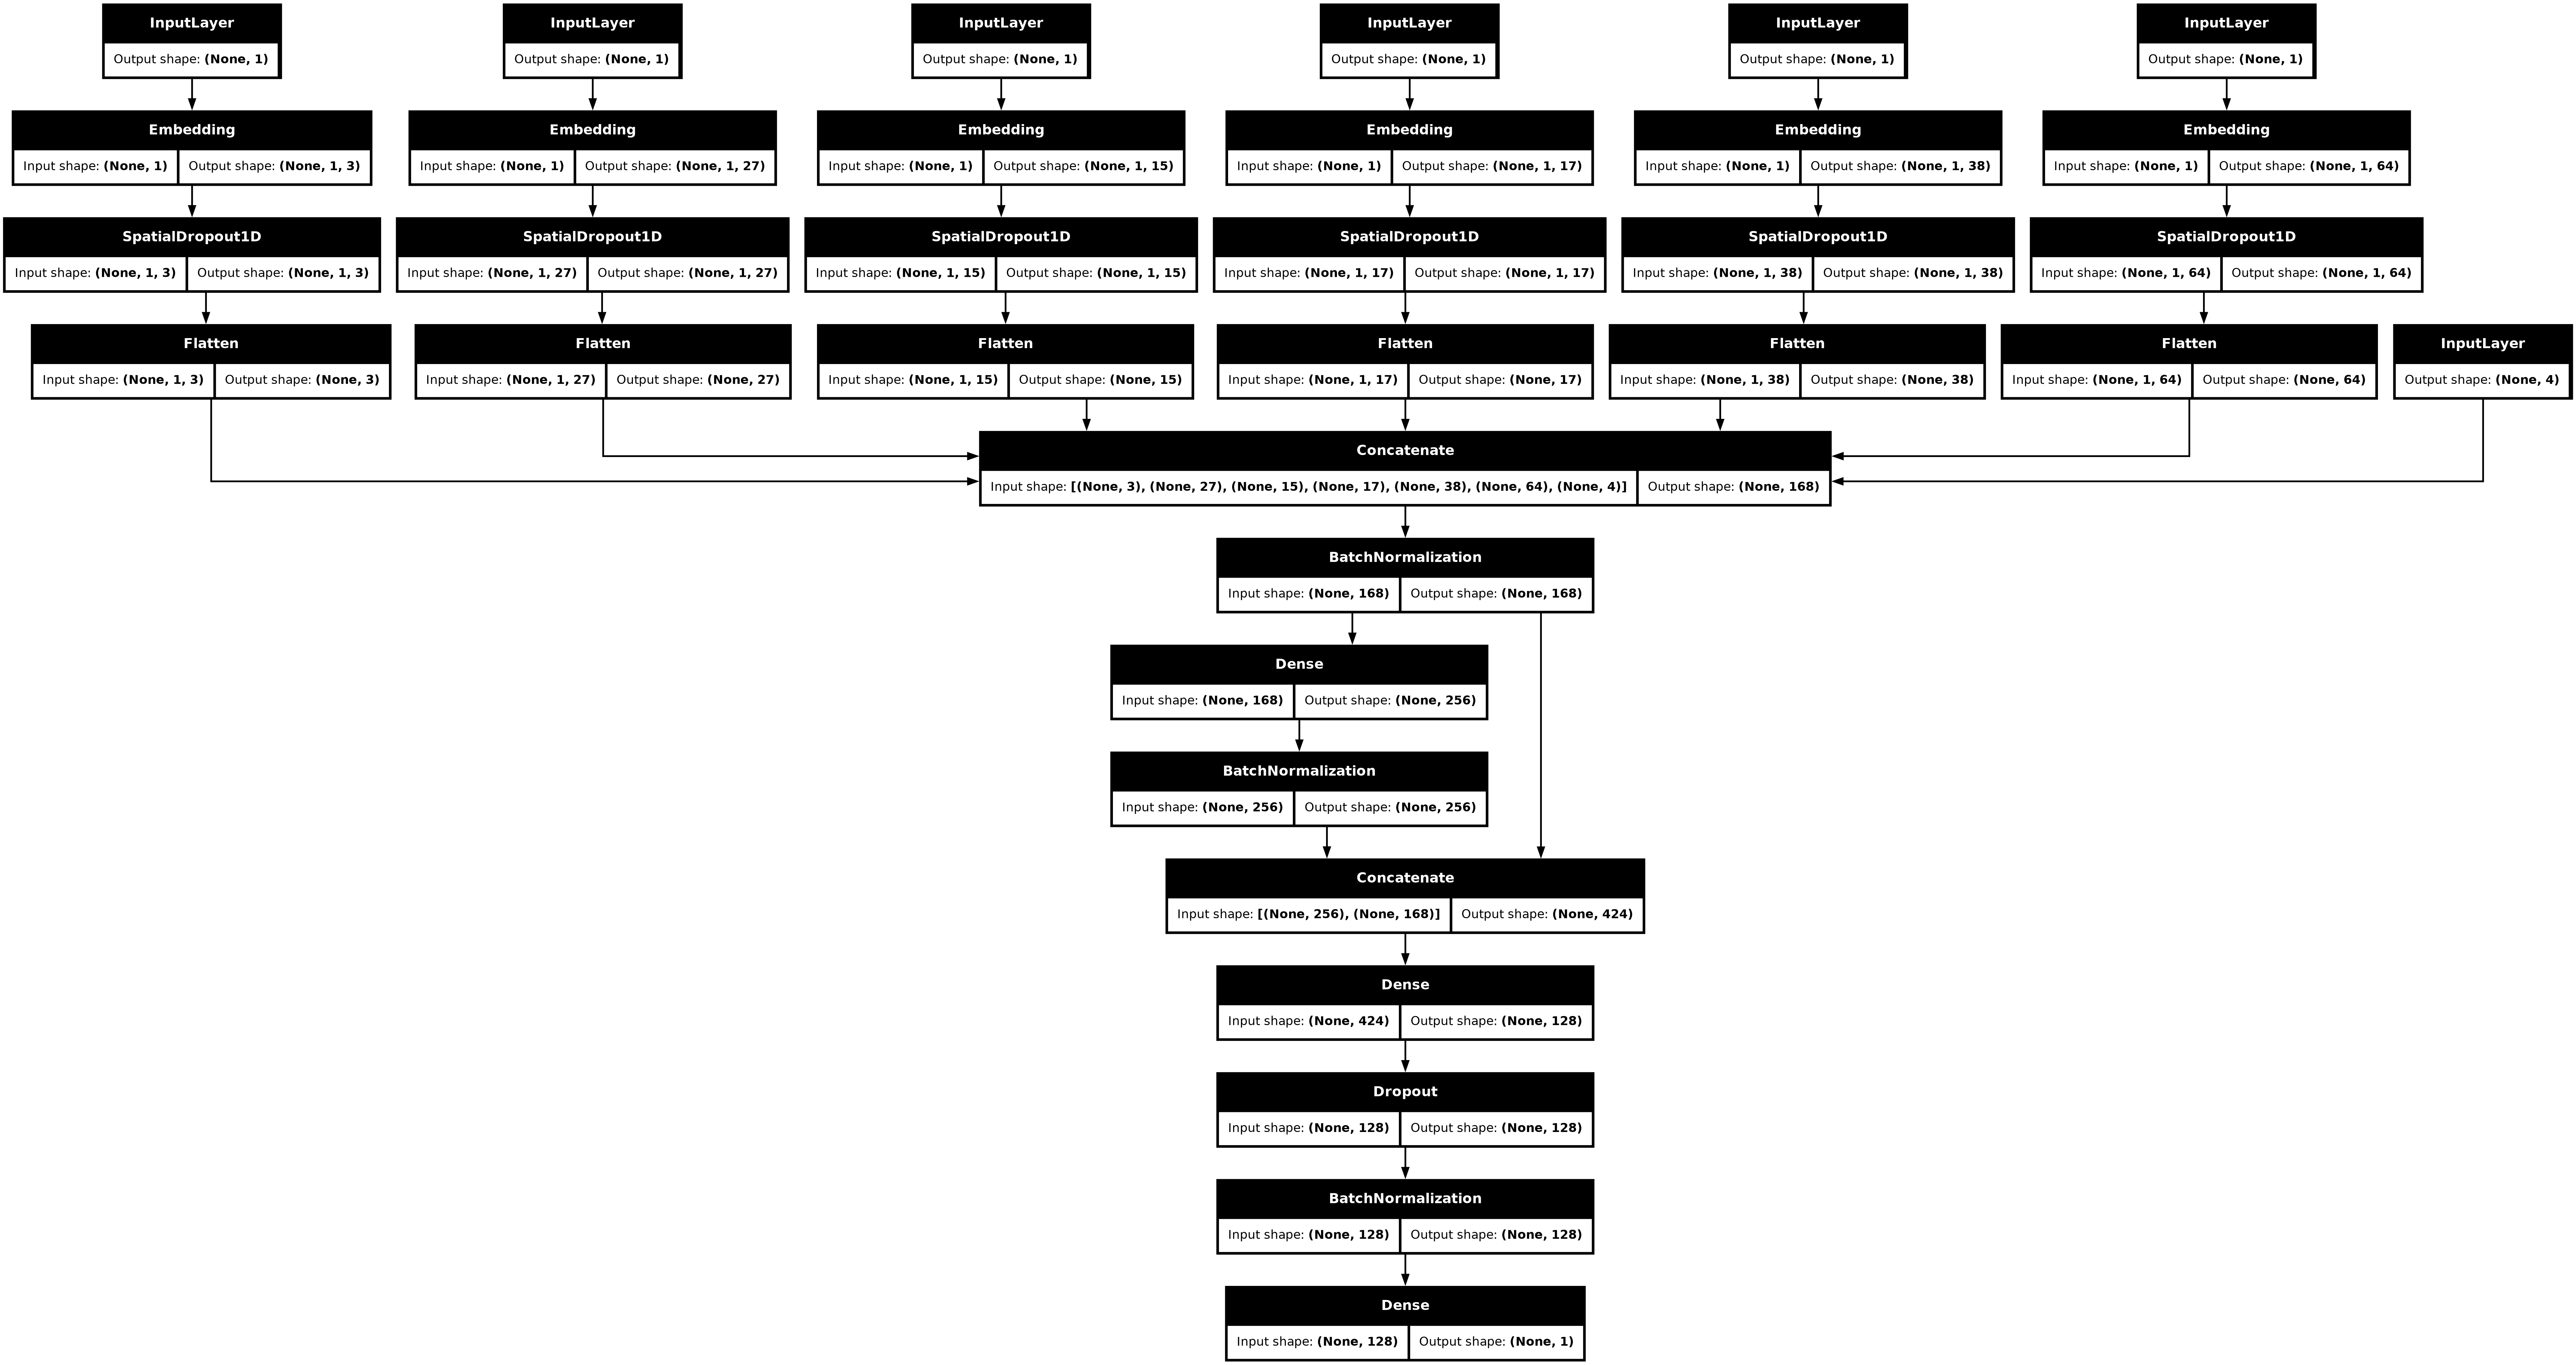

In [38]:
tf.keras.utils.plot_model(
    model=build_model(cat_features, cont_features), 
    show_shapes=True, 
    rankdir='TB')

# Fit

In [39]:
def fold_logloss(y, preds):
    return metrics.log_loss(y, preds)

def fold_auc(y, preds):
    return metrics.roc_auc_score(y, preds)

# to feed data into the NN
# we feed the categoricals column by column,
# and the continuous features in one lump.
cat_idxs= []
cont_idxs = []
for f in cat_features:
    cat_idxs.append([features.index(f)])
for f in cont_features:
    cont_idxs.append(features.index(f))
    
feature_idxs = cat_idxs + [cont_idxs]

def to_nn_feed(df):
    X = df[feats].values
    result = []
    for f_idx in feature_idxs:
        # housekeeping: to feed data into the NN
        # we feed the categoricals column by column,
        # and the continuous features in one lump.
        result.append(X[:, f_idx])
    return result

def fit_fold(tr, vl, ts):

    model = build_model(cat_features, cont_features)
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1E-4),
        loss='binary_crossentropy',
        metrics=['auc'])

    history = model.fit(
          to_nn_feed(tr), tr[TARGET_NAME],
          validation_data=(to_nn_feed(vl), vl[TARGET_NAME]),
          batch_size=BS,
          epochs=epochs,
          callbacks=callbacks,
          verbose=0
    )

    vl_pred = model.predict(to_nn_feed(vl), verbose=0, batch_size=BS).flatten()
    ts_pred = model.predict(to_nn_feed(ts), verbose=0, batch_size=BS).flatten()
    
    vl_metric = fold_auc(vl[TARGET_NAME], vl_pred)
    return vl_pred, ts_pred, vl_metric

In [43]:
N_FOLDS = 5
BS = 3000
feats = features

vl_preds = np.zeros(len(train_data))
ts_preds = np.zeros(len(test_data))
vl_metrics = []

keras.utils.set_random_seed(RANDOM_STATE)
k_fold = StratifiedKFold(n_splits=N_FOLDS, random_state=RANDOM_STATE, shuffle=True)
for tr_idx, vl_idx in k_fold.split(train_data, train_data[TARGET_NAME]):
    tr = train_data.loc[tr_idx]
    vl = train_data.loc[vl_idx]

    vl_pred, ts_pred, vl_metric = fit_fold(tr, vl, test_data)
    
    print(f'  -- fold auc {vl_metric:2.6f}')
    vl_metrics.append(vl_metric)
    vl_preds[vl_idx] += vl_pred
    ts_preds += ts_pred / N_FOLDS

# overall metric:
vl_metric = fold_auc(
    train_data[TARGET_NAME], vl_preds)
print(f'  ----------- {vl_metric:2.6f}')

W0000 00:00:1721747850.756046     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721747893.872174     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  -- fold auc 0.891554


W0000 00:00:1721748027.050510     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721748069.027656     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  -- fold auc 0.891120


W0000 00:00:1721748201.613108     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721748243.789910     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  -- fold auc 0.891657


W0000 00:00:1721748375.300785     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  -- fold auc 0.891019


W0000 00:00:1721748550.350026     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  -- fold auc 0.891529
  ----------- 0.891147


# How we doin'?

In [19]:
df_metrics = pd.DataFrame({'oof': vl_metrics})
print(ggplot(df_metrics, aes(x='oof'))
    + theme_light()
    + theme(figure_swdddddize=(6, 3))
    + geom_dotplot(alpha=0.3, binwidth = 1E-4, fill='SteelBlue')
    + geom_vline(xintercept=np.mean(vl_metrics), linetype='dashed')
    + labs(y = '', x='', title = f'OOF Metric Distribution\nAUC={np.mean(vl_metrics):0.4f}'))

PlotnineError: 'There no themeable element called: figure_swdddddize'

# Submission

In [20]:
# oof data
(train_data
    .filter(['id', TARGET_NAME])
    .assign(oof = vl_preds)
    .to_csv('oof.csv', index=False))

pd.read_csv('oof.csv').head(20)

,id,Response,oof
0,0,0.0,0.267362
1,1,1.0,0.383127
2,2,0.0,0.000083
3,3,0.0,0.200412
4,4,0.0,0.000160
5,5,0.0,0.000130
6,6,0.0,0.000138
7,7,1.0,0.210409
8,8,0.0,0.000021
9,9,0.0,0.287710


In [22]:
submission_filename = f'submission_NN_embeding_model.csv'

(test_data
    .assign(**{
        TARGET_NAME: ts_preds})
    .to_csv(submission_filename, columns=['id', 'Response'], index=False))

In [ ]:
pd.read_csv(submission_filename).head(20)